In [1]:
import numpy as np

import tensorflow as tf
print(tf.__version__)  # 2.7.0

from tensorflow.keras.utils import image_dataset_from_directory

from tensorflow import keras
from tensorflow.keras import layers

2.7.0


In [2]:
#new_base_dir = 'C:/Users/m85302/Desktop/data4_local/astro_data/galaxy_zoo_data/chollet_format_galaxy_zoo_data/galzoo_feat_vs_smooth_small/'

new_base_dir = 'C:/Users/m85302/Desktop/data4_local/astro_data/galaxy10_data/jpgCreated_Galaxy10_data/galaxy10_binary_Chollet-Format_1/'

In [3]:
train_dataset = image_dataset_from_directory(
    #new_base_dir / "train",
    new_base_dir + "/train/",
    #image_size=(180, 180),
    image_size=(69, 69),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    #new_base_dir / "validation",
    new_base_dir  + "/validation/",
    #image_size=(180, 180),
    image_size=(69, 69),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    #new_base_dir / "test",
    new_base_dir + "/test/",
    #image_size=(180, 180),
    image_size=(69, 69),
    batch_size=32)

Found 2036 files belonging to 2 classes.
Found 1014 files belonging to 2 classes.
Found 2042 files belonging to 2 classes.


In [4]:
# check gpu availability (jeff heaton . . . )

import tensorflow as tf
print(tf.__version__)

from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()

def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

for d in devices:
    t = d.device_type
    name = d.physical_device_desc
    l = [item.split(':',1) for item in name.split(", ")]
    name_attr = dict([x for x in l if len(x)==2])
    dev = name_attr.get('name', 'Unnamed device')
    print(f" {d.name} || {dev} || {t} || {sizeof_fmt(d.memory_limit)}")
    
# /device:CPU:0 || Unnamed device || CPU || 256.0 MiB
# /device:GPU:0 ||  Quadro T2000 || GPU || 2.1 GiB

2.7.0
 /device:CPU:0 || Unnamed device || CPU || 256.0 MiB
 /device:GPU:0 ||  Quadro T2000 || GPU || 2.1 GiB


### Y. Transfer learning, VGG16

In [ ]:
## EfficientNet

conv_base_efficientnet = keras.applications.EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

conv_base_efficientnet.summary()

In [5]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    
    #input_shape=(180, 180, 3))
    input_shape=(69, 69, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 69, 69, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 69, 69, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 69, 69, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 34, 34, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 34, 34, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 34, 34, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 17, 17, 128)       0     

In [8]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        
        #preprocessed_images = keras.applications.efficientnet.preprocess_input(images) # figure this out
        #features = conv_base_efficientnet.predict(preprocessed_images)
        
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

In [9]:
%%time

#print('EfficientNetB0 Base:')
print('VGG16 Base:')

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

## VGG16 Base: (180x180)
## Wall time: 1min 22s

# Galaxy10:, 69x69
#VGG16 Base:
#Wall time: 24.1 s

VGG16 Base:
Wall time: 24.1 s


In [10]:
train_features.shape

(2036, 2, 2, 512)

**Defining and training the densely connected classifier**

In [14]:
#inputs = keras.Input(shape=(6,6,1280))
#inputs = keras.Input(shape=(5, 5, 512))

inputs = keras.Input(shape=(2, 2, 512))

x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [15]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]

In [16]:
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
64/64 [==============================] - 1s 10ms/step - loss: 2.3861 - accuracy: 0.8792 - val_loss: 0.5088 - val_accuracy: 0.9536
Epoch 2/20
64/64 [==============================] - 0s 5ms/step - loss: 0.9864 - accuracy: 0.9401 - val_loss: 1.5674 - val_accuracy: 0.9142
Epoch 3/20
64/64 [==============================] - 0s 5ms/step - loss: 0.7812 - accuracy: 0.9528 - val_loss: 0.7944 - val_accuracy: 0.9428
Epoch 4/20
64/64 [==============================] - 0s 6ms/step - loss: 0.6633 - accuracy: 0.9524 - val_loss: 0.3837 - val_accuracy: 0.9675
Epoch 5/20
64/64 [==============================] - 0s 6ms/step - loss: 0.7240 - accuracy: 0.9489 - val_loss: 0.4537 - val_accuracy: 0.9625
Epoch 6/20
64/64 [==============================] - 0s 6ms/step - loss: 0.5712 - accuracy: 0.9641 - val_loss: 0.6496 - val_accuracy: 0.9507
Epoch 7/20
64/64 [==============================] - 0s 6ms/step - loss: 0.5501 - accuracy: 0.9607 - val_loss: 1.3622 - val_accuracy: 0.9231
Epoch 8/20
64/64 [=

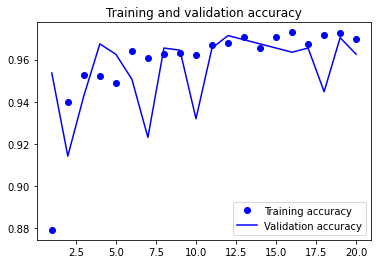

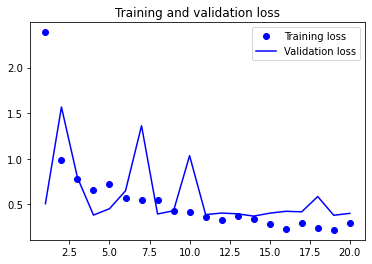

In [17]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### Y. xAI with LIME-Image